<a href="https://colab.research.google.com/github/VardhanVelamakanni/Mental_stres_Prediction_BandDecomposition_CWT/blob/main/Trainingcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving Pipeline1_dataset.zip to Pipeline1_dataset.zip
Saving Pipeline2_dataset.zip to Pipeline2_dataset.zip
Saving Pipeline3_dataset.zip to Pipeline3_dataset.zip
Saving Pipeline4_dataset.zip to Pipeline4_dataset.zip


In [3]:
import zipfile, os

pipelines = ["pipeline1","pipeline2","pipeline3","pipeline4"]

for p in pipelines:
    with zipfile.ZipFile(f"{p}.zip",'r') as z:
        z.extractall(f"/content/{p}")

print("All datasets extracted")


All datasets extracted


In [4]:
!pip install torch torchvision matplotlib


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [18]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,2)
        )

    def forward(self,x):
        return self.classifier(self.features(x))


In [22]:
def train_pipeline(dataset_path, epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_data = datasets.ImageFolder(dataset_path+"/train", transform)
    val_data   = datasets.ImageFolder(dataset_path+"/val", transform)
    test_data  = datasets.ImageFolder(dataset_path+"/test", transform)

    train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
    test_loader  = DataLoader(test_data,batch_size=32)

    model = SimpleCNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # TRAIN
    for ep in range(epochs):
        model.train()
        for x,y in train_loader:
            x,y = x.to(device),y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x),y)
            loss.backward()
            optimizer.step()

        print(f"{dataset_path} Epoch {ep+1}/{epochs} done")

    # TEST
    model.eval()
    correct,total = 0,0

    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(device),y.to(device)
            pred = torch.argmax(model(x),1)
            correct += (pred==y).sum().item()
            total += y.size(0)

    return correct/total


In [23]:
accuracies = {}

for p in pipelines:
    acc = train_pipeline("/content/"+p, epochs=15)
    accuracies[p] = acc


/content/pipeline1 Epoch 1/15 done
/content/pipeline1 Epoch 2/15 done
/content/pipeline1 Epoch 3/15 done
/content/pipeline1 Epoch 4/15 done
/content/pipeline1 Epoch 5/15 done
/content/pipeline1 Epoch 6/15 done
/content/pipeline1 Epoch 7/15 done
/content/pipeline1 Epoch 8/15 done
/content/pipeline1 Epoch 9/15 done
/content/pipeline1 Epoch 10/15 done
/content/pipeline1 Epoch 11/15 done
/content/pipeline1 Epoch 12/15 done
/content/pipeline1 Epoch 13/15 done
/content/pipeline1 Epoch 14/15 done
/content/pipeline1 Epoch 15/15 done
/content/pipeline2 Epoch 1/15 done
/content/pipeline2 Epoch 2/15 done
/content/pipeline2 Epoch 3/15 done
/content/pipeline2 Epoch 4/15 done
/content/pipeline2 Epoch 5/15 done
/content/pipeline2 Epoch 6/15 done
/content/pipeline2 Epoch 7/15 done
/content/pipeline2 Epoch 8/15 done
/content/pipeline2 Epoch 9/15 done
/content/pipeline2 Epoch 10/15 done
/content/pipeline2 Epoch 11/15 done
/content/pipeline2 Epoch 12/15 done
/content/pipeline2 Epoch 13/15 done
/content/p

In [24]:
for k,v in accuracies.items():
    print(k,"Accuracy:",round(v*100,2),"%")


pipeline1 Accuracy: 60.86 %
pipeline2 Accuracy: 79.48 %
pipeline3 Accuracy: 91.55 %
pipeline4 Accuracy: 60.47 %


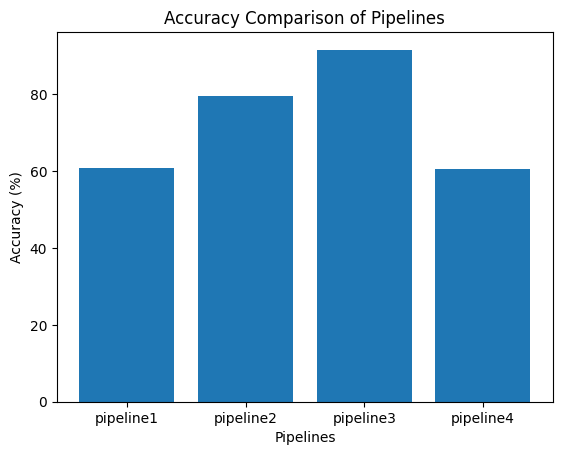

In [25]:
names = list(accuracies.keys())
values = [v*100 for v in accuracies.values()]

plt.figure()
plt.bar(names, values)
plt.xlabel("Pipelines")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of Pipelines")
plt.show()
